# ANNDL: 1st challenge


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [1]:
import numpy as np
import random

import gc #garbage collector
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

seed = 42
input_img_size = 96

np.random.seed(seed)
tf.random.set_seed(seed)

## ⏳ Load the Data

The data are loaded from the filtered, pre-processed data. For more details, see '''Preprocessing.ipynb''' notebook.

In [ ]:
filtered_dataset_path = '../Preprocessing/balanced_dataset.npz'
data = np.load(filtered_dataset_path)
N = int(len(data['images']) * 0.85)
X_train = data['images'][:N]
y_train = data['labels'][:N]


# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

18640
15844


In [3]:
# Normalize the data to the range [0, 1] and encode output labels
X_train = (X_train / 255).astype('float32')
y_train = tfk.utils.to_categorical(y_train, num_classes=len(unique_labels))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=seed, stratify=y_train)
print(f'Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}, Validation labels shape: {y_val.shape}')

Training data shape: (11090, 96, 96, 3), Validation data shape: (4754, 96, 96, 3)
Training labels shape: (11090, 8), Validation labels shape: (4754, 8)


## 🔆 Augmenting the training and validation set
We use AutoContrast and RandomSaturation from the keras library for the training set. It enhances contrast adaptively and may help in highlighting subtle differences between cell types without altering structure. 
We added the agumented images to the training set & we applied some rotation, zoom and shift.

We use RandAugment for the validation set. 

In [4]:
# Import keras
import keras_cv as kcv

c:\Users\motti\Documents\ANNDL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Implement AutoContrast
value_range = [0, 1]
autocontrast = kcv.layers.AutoContrast(value_range)
contrast_result = autocontrast({'images': X_train, 'labels': y_train})

In [6]:
# Implement RandomSaturation
factor = [0, 1]
randomsaturation = kcv.layers.RandomSaturation(factor, seed=seed)
saturation_result = randomsaturation({'images': X_train, 'labels': y_train})

In [7]:
# Implement Solarization
value_range = [0, 1]
solar = kcv.layers.Solarization(value_range)
sol_result = solar({'images': X_train, 'labels': y_train})

In [8]:
# Implement CutOut
cutout_layer = kcv.layers.RandomCutout(height_factor=0.5, width_factor=0.5, seed=seed)
cutout_result = cutout_layer({'images': X_train, 'labels': y_train})

In [9]:
X_train = np.concatenate((X_train, contrast_result["images"]), axis=0)
y_train = np.concatenate((y_train, contrast_result["labels"]), axis=0)

del contrast_result
gc.collect()

X_train = np.concatenate((X_train, saturation_result["images"]), axis=0)
y_train = np.concatenate((y_train, saturation_result["labels"]), axis=0)

del saturation_result
gc.collect() 

X_train = np.concatenate((X_train, cutout_result["images"]), axis=0)
y_train = np.concatenate((y_train, cutout_result["labels"]), axis=0)

del cutout_result
gc.collect()

X_train = np.concatenate((X_train, sol_result["images"]), axis=0)
y_train = np.concatenate((y_train, sol_result["labels"]), axis=0)

del sol_result
gc.collect()

0

In [10]:
# Augmenting validation set
randaugment = kcv.layers.RandAugment(value_range=(0,1), augmentations_per_image=3, magnitude=0.3)
val_augmented = randaugment(X_val)
print("val_agumented shape:", val_augmented.shape)
print("y_val shape:", y_val.shape)

val_agumented shape: (4754, 96, 96, 3)
y_val shape: (4754, 8)


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,         # Equivalent to RandomRotation
    width_shift_range=0.2,     # Equivalent to RandomTranslation on x-axis
    height_shift_range=0.2,    # Equivalent to RandomTranslation on y-axis
    zoom_range=0.2,            # Equivalent to RandomZoom
    horizontal_flip=True,      # Equivalent to RandomFlip (horizontal)
    vertical_flip=True         # Equivalent to RandomFlip (vertical)
)

train_generator = datagen.flow(X_train, y_train)

In [12]:
# Save in .zip file training and validation set
np.savez_compressed('aug_steroid_dataset', images_t=X_train, labels_t=y_train, images_v = val_augmented, labels_v = y_val)

## Transfer Learning

In [46]:
# Initialise densenet model with pretrained weights, for transfer learning
dense = tfk.applications.densenet.DenseNet121(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling=None,
    classifier_activation='softmax'
)

# Display a summary of the model architecture
# dense.summary(expand_nested=True)

In [49]:
# Freeze all layers in DenseNet to use it solely as a feature extractor
dense.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Preprocess inputs for DenseNet
x = tfk.applications.densenet.preprocess_input(inputs)

# Pass inputs through the feature extractor
x = dense(inputs)

# Add a Global Average Pooling layer to flatten the spatial dimensions
x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.5, name='dropout')(x)

# Add final Dense layer for classification with L2 regularization
outputs = tfkl.Dense(8, activation='softmax', kernel_regularizer=tfk.regularizers.l2(0.001), name='output_reg_l2')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Lion optimiser
optimizer = tfk.optimizers.AdamW()
# optimizer = tfk.optimizers.Adam()
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

# Display a summary of the model architecture
# tl_model.summary(expand_nested=True)

In [50]:
# Early stopping to stop the training when val_accuracy stop to increase
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=2,
    restore_best_weights=True
)

# Reduce LR when val_loss stop to decrease to avoid local minumum
reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=2
)

# ModelCheckpoint save the best weights along the training 
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath='best_model.keras',  
    monitor='val_loss',        
    save_best_only=True        
)

callbacks = [early_stopping, reduce_lr_on_plateau, checkpoint]

In [51]:
# Train the model
tl_history = tl_model.fit(
    train_generator,
    batch_size=16,
    epochs=6,
    validation_data=(val_augmented, y_val),
    callbacks=callbacks
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'TL_dense_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/6
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 557s 314ms/step - accuracy: 0.5050 - loss: 1.6275 - val_accuracy: 0.6231 - val_loss: 1.2499 - learning_rate: 0.0010
Epoch 2/6
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 539s 311ms/step - accuracy: 0.6618 - loss: 0.9975 - val_accuracy: 0.5944 - val_loss: 1.3314 - learning_rate: 0.0010
Epoch 3/6
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 537s 310ms/step - accuracy: 0.6591 - loss: 1.0036 - val_accuracy: 0.6197 - val_loss: 1.2726 - learning_rate: 0.0010
Final validation accuracy: 62.31%


## Fine Tuning

In [52]:
# Re-load the best model after transfer learning
ft_model = tfk.models.load_model("best_model.keras")

In [53]:
ft_model.get_layer('densenet121').trainable = True

# Set all DenseNet121 layers as non-trainable
for layer in ft_model.get_layer('densenet121').layers:
    layer.trainable = False

# Enable training only for Conv2D layers
for i, layer in enumerate(ft_model.get_layer('densenet121').layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 conv1_conv Conv2D True
9 conv2_block1_1_conv Conv2D True
12 conv2_block1_2_conv Conv2D True
16 conv2_block2_1_conv Conv2D True
19 conv2_block2_2_conv Conv2D True
23 conv2_block3_1_conv Conv2D True
26 conv2_block3_2_conv Conv2D True
30 conv2_block4_1_conv Conv2D True
33 conv2_block4_2_conv Conv2D True
37 conv2_block5_1_conv Conv2D True
40 conv2_block5_2_conv Conv2D True
44 conv2_block6_1_conv Conv2D True
47 conv2_block6_2_conv Conv2D True
51 pool2_conv Conv2D True
55 conv3_block1_1_conv Conv2D True
58 conv3_block1_2_conv Conv2D True
62 conv3_block2_1_conv Conv2D True
65 conv3_block2_2_conv Conv2D True
69 conv3_block3_1_conv Conv2D True
72 conv3_block3_2_conv Conv2D True
76 conv3_block4_1_conv Conv2D True
79 conv3_block4_2_conv Conv2D True
83 conv3_block5_1_conv Conv2D True
86 conv3_block5_2_conv Conv2D True
90 conv3_block6_1_conv Conv2D True
93 conv3_block6_2_conv Conv2D True
97 conv3_block7_1_conv Conv2D True
100 conv3_block7_2_conv Conv2D True
104 conv3_block8_1_conv Conv2D True
107

In [54]:
# Set the number of layers to freeze
N = 100

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('densenet121').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('densenet121').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
#ft_model.summary(expand_nested=True)

0 input_layer_2 False
1 zero_padding2d_4 False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 zero_padding2d_5 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_b

In [55]:
# Lowering the learning rate for fine-tuning
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(0.0001), metrics=['accuracy'])

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=2,
    restore_best_weights=True
)

reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=0.0
)

callbacks = [early_stopping, reduce_lr_on_plateau]

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_generator, 
    batch_size = 32,
    epochs = 20,
    validation_data = (val_augmented, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/20
1266/1733 ━━━━━━━━━━━━━━━━━━━━ 4:29 576ms/step - accuracy: 0.8132 - loss: 0.5476

## Evaluate and save the model

149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step


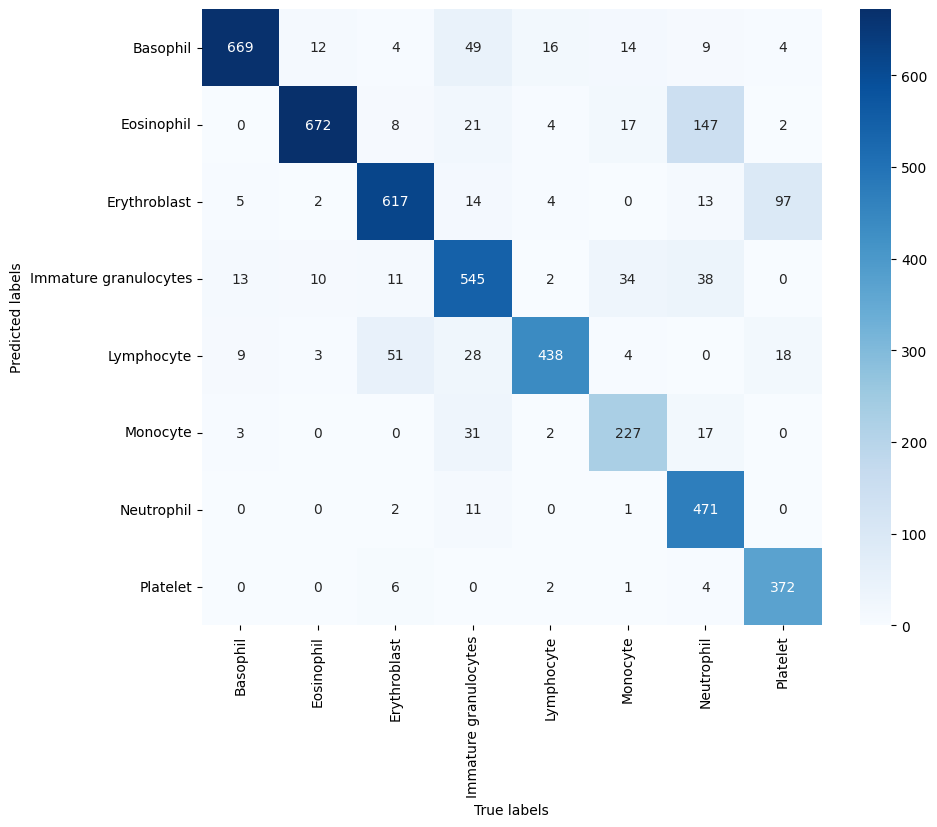

In [ ]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Compute the confusion matrix
predictions = model.predict(val_augmented)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)
cm = confusion_matrix(true_classes, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

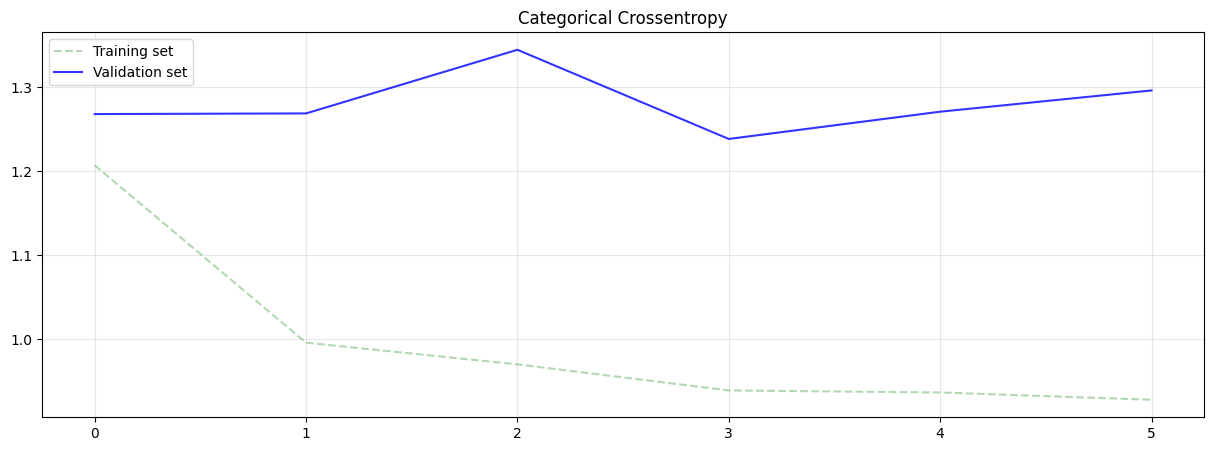

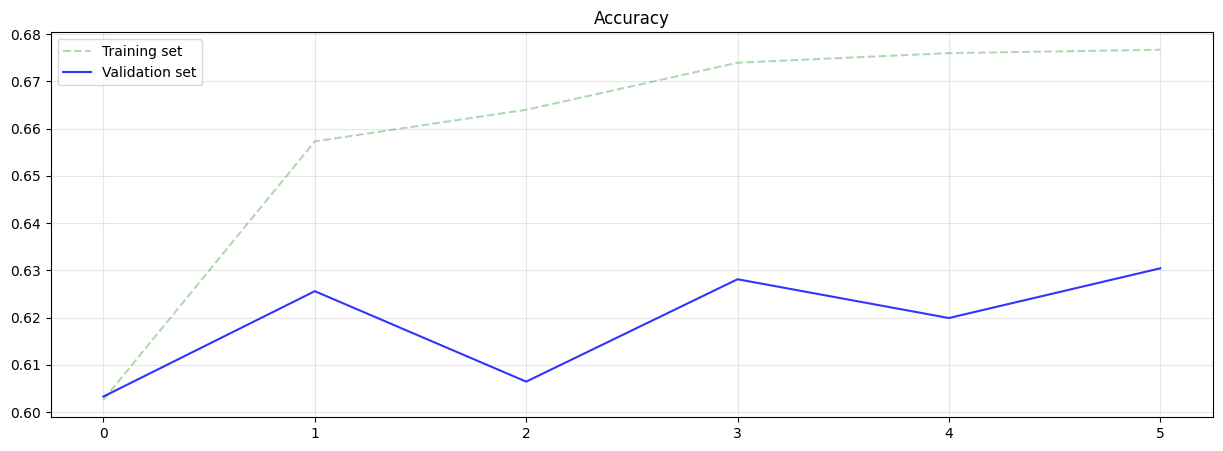

In [ ]:
# Plot the loss and accuracy metrics
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```


In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
# Create the .zip file to be submitted
import os
import zipfile

# Check if model.py and weights.keras exist
if os.path.exists("model.py") and os.path.exists("weights.keras"):
    # Create a ZIP file containing model.py and weights.keras
    with zipfile.ZipFile("sub.zip", "w") as model_zip:
        model_zip.write("model.py")
        model_zip.write("weights.keras")
    print("model.zip has been created successfully.")
else:
    print("model.py or weights.keras not found. Please ensure both files are in the current directory.")

model.zip has been created successfully.
